<center><span style="font-size:36px;">  🏈Raw Tackle Ability and Tackle Index🏈</span> </center>

***

### <font color='289C4E'  align>Table of contents<font><a class='anchor' id='top'></a>
- [Import Data](#1)
- [Standardize Directional Data](#2)
- [Merge the Data](#3)
- [Create summary of game](#4)
- [Exploratory Data Analysis](#5)
- [Modeling](#6)
- [Explaining the Model](#7)
- [Stats by Tackler](#8)
- [NFL Use Cases](#9)
- [GIF/Animation](#10) 


***

## Introduction

At a basic level, tackling is crucial to the game of football in several ways:
 - **Preventing yards gained:** Defensive tackling is a key way to prevent the offensive team from gaining additiongl yardage. When executed at the right moment, a successful tackle can put the opposing team in unfavorable conditions.
 - **Preventing scoring:** When every point counts, a successful tackle can make the difference between winning and losing a game. By preventing a player from reaching the end zone and forcing the opposing team to attempt field goals, tacklers limit points scored.
 - **Creating turnovers:** If a defender can tackle effectively and lead to a forced fumble, their own team can gain posession of the ball and get the chance to score more points.
 
 

### Project Goal:
Our goal is to analyze historical tracking data and extract meaningful features to predict when a tackle attempt will be successful. We will then apply the model to players and determine their "Raw Tackle Ability", which we define as "the probability that a player will make a successful tackle based on their previous behavior."

We also introduce the "Tackle Index", which allows us to rank players based on their current track record related to tackling in addition to their Raw Tackle Ability (RTA). This accounts for consistent performance and number of games played.

***

# 1. Import Data <a class="anchor"  id="1"></a>

The first thing I'm going to do is read all of the data. For the tracking data, I'm going to concatenate the dataframes so that there is one comprehensive dataframe with all of the tracking info.

In [1]:
import warnings
#!pip install eli5
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
"""df_games=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')
df_players=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
df_plays=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
df_tackles=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')
files=[]
for i in range(1,10):
    file='/kaggle/input/nfl-big-data-bowl-2024/tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files) 
"""


"df_games=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')\ndf_players=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')\ndf_plays=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')\ndf_tackles=pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')\nfiles=[]\nfor i in range(1,10):\n    file='/kaggle/input/nfl-big-data-bowl-2024/tracking_week_'+str(i)+'.csv'\n    files.append(pd.read_csv(file))\n    df_tracking=pd.concat(files) \n"

In [2]:
df_games=pd.read_csv('games.csv')
df_players=pd.read_csv('players.csv')
df_plays=pd.read_csv('plays.csv')
df_tackles=pd.read_csv('tackles.csv')
files=[]
for i in range(1,10):
    file='tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files)

In [3]:
df_tackles.describe()

gameId        playId         nflId        tackle        assist  \
count  1.742600e+04  17426.000000  17426.000000  17426.000000  17426.000000   
mean   2.022099e+09   1982.974578  47602.719442      0.569207      0.315276   
std    5.978775e+03   1170.990596   4846.585868      0.495201      0.464639   
min    2.022091e+09     54.000000  33131.000000      0.000000      0.000000   
25%    2.022093e+09    952.000000  43797.000000      0.000000      0.000000   
50%    2.022101e+09   1991.000000  46669.000000      1.000000      0.000000   
75%    2.022102e+09   2981.750000  52546.000000      1.000000      1.000000   
max    2.022111e+09   5096.000000  55241.000000      1.000000      1.000000   

       forcedFumble  pff_missedTackle  
count  17426.000000      17426.000000  
mean       0.005681          0.119936  
std        0.075161          0.324896  
min        0.000000          0.000000  
25%        0.000000          0.000000  
50%        0.000000          0.000000  
75%        0.000000          0.000000  
max        1.000000          1.000000

# 2. Standardize Directional Data <a class="anchor"  id="2"></a>

I used this notebook to standardize all of my directional data: 
https://www.kaggle.com/code/colinlagator/make-all-plays-left-right 

In [4]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [5]:
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
        
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])
        
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
        
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [6]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))

df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [7]:
print('Distinct plays in tracking data: ', df_tracking['gameplayid'].nunique())
print('Distinct plays in play data: ', df_plays['gameplayid'].nunique())
print('Distinct plays in tackles data: ', df_tackles['gameplayid'].nunique())

Distinct plays in tracking data:  12486
Distinct plays in play data:  12486
Distinct plays in tackles data:  12025


# 3. Merge the data <a class="anchor"  id="3"></a>

In [8]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )
    df_tracking_plays_final['event']=np.where(df_tracking_plays_final['tackle']==1, 'tackle', np.where(df_tracking_plays_final['pff_missedTackle']==1, 'missed_tackle', (np.where(df_tracking_plays_final['assist']==1, 'assist', 'Other')) ))
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], how='inner', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[( (df_tackles_final['tackle']+df_tackles_final['assist']+df_tackles_final['pff_missedTackle']>=1)&(df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [9]:

print('Distinct plays in  final data: ', df_tackles_final['gameplayid'].nunique())
print('Distinct frames in  final data: ', df_tackles_final['index'].nunique())

Distinct plays in  final data:  12022
Distinct frames in  final data:  17420


In [10]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)
df_ballcarrier.head()

gameplayid  frameId  x_ballcarrier  y_ballcarrier  s_ballcarrier  \
0  202209080056        1          88.37          27.27           1.62   
1  202209080056        2          88.47          27.13           1.67   
2  202209080056        3          88.56          27.01           1.57   
3  202209080056        4          88.64          26.90           1.44   
4  202209080056        5          88.72          26.80           1.29   

   a_ballcarrier  dis_ballcarrier  o_ballcarrier  dir_ball_carrier  \
0           1.15             0.16         231.74            147.90   
1           0.61             0.17         230.98            148.53   
2           0.49             0.15         230.98            147.05   
3           0.89             0.14         232.38            145.42   
4           1.24             0.13         233.36            141.95   

  event_ballcarrier  ...  dir_standard_ballcarrier  x_standard_ballcarrier  \
0               NaN  ...                    327.90                   31.63   
1      pass_arrived  ...                    328.53                   31.53   
2               NaN  ...                    327.05                   31.44   
3               NaN  ...                    325.42                   31.36   
4               NaN  ...                    321.95                   31.28   

   y_standard_ballcarrier  nflId_ballcarrier  ballCarrierHeight  \
0               26.063333              35472                6-5   
1               26.203333              35472                6-5   
2               26.323333              35472                6-5   
3               26.433333              35472                6-5   
4               26.533333              35472                6-5   

  ballCarrierWeight  ballcarrierDOB ballcarrierCollege ballcarrierPosition  \
0               325      1988-06-06            Indiana                   G   
1               325      1988-06-06            Indiana                   G   
2               325      1988-06-06            Indiana                   G   
3               325      1988-06-06            Indiana                   G   
4               325      1988-06-06            Indiana                   G   

  ballCarrierDisplayName  
0         Rodger Saffold  
1         Rodger Saffold  
2         Rodger Saffold  
3         Rodger Saffold  
4         Rodger Saffold  

[5 rows x 21 columns]

In [11]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={'nflId':'nflId_tackler', 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)

## Key Metrics from Physics
We decided to borrow a few concepts from basic physics to calculate additional metrics for the players (tackler and ball carrier). 
 - Force = Mass x Acceleration
 - Momentum = Mass x Speed
 - Relative velocity
 
 # Relative Velocity and the Coefficient of Restitution: 
- In physics, there are two types of collisions: elastic and inelastic. An elastic collision results in objects moving apart at the same rate at which they collided. On the other hand, an inelastic collision results in objects staying stuck together. According to [The University of Arkansas ](https://phys.libretexts.org/Courses/Merrimack_College/Conservation_Laws_Newton's_Laws_and_Kinematics_version_2.0/08%3A_C8_Conservation_of_Energy-_Kinetic_and_Gravitational/8.05%3A_Relative_Velocity_and_the_Coefficient_of_Restitution) you can quantify how elastic a collision is with the coefficient of restitution (COR). Typically football tackles are classified as inelastic collisions, but we'd like to use the COR to quantify how inelastic a tackle is.

We are suggesting an adjusted COR which adds 1 to the numerator and denominator to account for division by 0.
 

## COR= 
## $\frac{(v_{2f} - v_{1f})+1}{(v_{2i} - v_{1i})+1}$

In [12]:
def create_force_features(df_full):
    df_full['force_ballcarrier']=df_full['ballCarrierWeight']*df_full['a_ballcarrier']
    df_full['force_tackler']=df_full['tacklerWeight']*df_full['a_tackler']
    df_full['momentum_ballcarrier']=df_full['ballCarrierWeight']*df_full['s_ballcarrier']
    df_full['momentum_tackler']=df_full['tacklerWeight']*df_full['s_tackler']
    #calculate distance between player tackling and player being tackled
    df_full['dis_ballcarrier_tackler']=np.sqrt(((df_full['x_standard_ballcarrier'] -df_full['x_standard_tackler'])**2)+((df_full['y_standard_ballcarrier'] -df_full['y_standard_tackler'])**2))
    return df_full
df_full=create_force_features(df_full)


In [13]:
import time

def minutes_to_seconds(minutes):
  return minutes * 60

def seconds_to_minutes(seconds):
  return seconds // 60
def convert_minutes_to_seconds(hours_minutes_and_seconds):
  hours, minutes, seconds = hours_minutes_and_seconds.split(':')
  return minutes_to_seconds(int(minutes)) + seconds_to_minutes(float(seconds))




In [14]:
import datetime 
from datetime import datetime

df_full['time']=df_full['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f' ))
df_full['time_adj']=df_full['time'].apply(lambda x: x.time())
df_full['time_seconds']=df_full['time_adj'].apply(lambda x: convert_minutes_to_seconds(str(x)))


In [15]:

df_full['time_elapsed']=df_full.groupby(['gameplayid', 'frameId'])['time_seconds'].diff()
df_full['nflId_tackler']=df_full['nflId_tackler'].astype(str)
df_full['nflId_ballcarrier']=df_full['nflId_ballcarrier'].astype(str)


In [16]:
df_full.sort_values(by=['gameplayid', 'frameId'], inplace=True)


In [17]:

df_full['relative_direction']=df_full['dir_standard_tackler']-df_full['dir_standard_ballcarrier']
df_full['relative_o']=df_full['o_standard_tackler']-df_full['o_standard_ballcarrier']
df_full['playNullifiedByPenalty'].replace({'Y':1, 'N':0}, inplace=True)

In [18]:
df_groupplay=df_full.groupby(by=['gameplayid', 'displayName'])['dis_ballcarrier_tackler'].min().reset_index()
df_groupplay['tackleframe']=1
df_full=pd.merge(df_groupplay, df_full, left_on=['gameplayid', 'displayName', 'dis_ballcarrier_tackler'], right_on=['gameplayid','displayName', 'dis_ballcarrier_tackler'], how='right')
df_full['tackle_frame_final']=np.where((df_full['tackleframe']==1), 1, 0)
df_full['prior_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(1)
df_full['next_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(-1)
df_full['prior_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(1)
df_full['next_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(-1)


In [19]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName']).agg({'playNullifiedByPenalty':'max', 'relative_o':'mean', 'relative_direction':'mean', 'time':['min', 'max'], 'time_seconds':['min', 'max'],'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean'], 'y_tackler':['min', 'max','mean'],
                                  's_tackler':['first', 'last','min', 'max','mean'], 'a_tackler':['min', 'max','mean'], 'dis_tackler':['min', 'max','mean'],
                                  'o_tackler':['min', 'max','mean'], 'dir_tackler':['min', 'max','mean'], 'o_standard_tackler':['min', 'max','mean'],
                                  'dir_standard_tackler':['min', 'max','mean'], 'x_standard_tackler':['min', 'max','mean'], 'y_standard_tackler':['min', 'max','mean'],
                                  'quarter':['min', 'max','mean'], 'down':['min', 'max','mean'], 'yardsToGo':['min', 'max','mean'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean'], 'preSnapVisitorScore':['min', 'max','mean'],
                                  'passLength':['min', 'max','mean'], 'absoluteYardlineNumber':['min', 'max','mean'], 'defendersInTheBox': ['min', 'max','mean'],
                                  'expectedPoints':['min', 'max','mean'], 'tackle':'max', 'assist':'max',  'pff_missedTackle':'max', 'tacklerWeight': 'mean',
                                  'x_ballcarrier': ['min', 'max','mean'], 'y_ballcarrier':['min', 'max','mean'], 's_ballcarrier':['first', 'last','min', 'max','mean'],
                                  'a_ballcarrier':['min', 'max','mean'], 'dis_ballcarrier': ['min', 'max','mean'], 'o_ballcarrier':['min', 'max','mean'],
                                  'o_standard_ballcarrier':['min', 'max','mean'],'dir_standard_ballcarrier':['min', 'max','mean'],
                                  'x_standard_ballcarrier':['min', 'max','mean'], 'y_standard_ballcarrier':['min', 'max','mean'], 'ballCarrierWeight':'mean', 'force_ballcarrier':['min', 'max','mean'],
                                  'force_tackler':['min', 'max','mean']}).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)


## Summary Statistics

In [20]:
print('Total plays: ', df_full_grouped['gameplayid'].nunique())
print('Total plays not nullified by penalty: ', df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]['gameplayid'].nunique())
print('Total row count: ', len(df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]))
print('Total missed tackles: ', len(df_full_grouped[(df_full_grouped['pff_missedTackle|max']==1)]['gameplayid']))
print('Total assists: ', len(df_full_grouped[((df_full_grouped['assist|max']==1)&(df_full_grouped['pff_missedTackle|max']==0))]['gameplayid']))
print('Total tackles: ', len(df_full_grouped[((df_full_grouped['tackle|max']==1)&(df_full_grouped['assist|max']==0)&(df_full_grouped['pff_missedTackle|max']==0))]['gameplayid']))

Total plays:  12022
Total plays not nullified by penalty:  11700
Total row count:  16988
Total missed tackles:  2090
Total assists:  5446
Total tackles:  9884


In [21]:
##remove plays nullified by penalty 
df_full_grouped=df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]

In [22]:
df_speed_subset=df_full[df_full['tackle_frame_final']==1][['gameplayid', 'displayName', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier']]

In [23]:
df_speed_subset.fillna(0, inplace=True)

Just for an extra resource, I'm going to create descriptions of each game by adding all the play descriptions together for each game.

# 4. Create summary of game <a class="anchor"  id="4"></a>

In [24]:
df_playdescription = df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).set_index('gameId')
df_gamedescription=df_playdescription.groupby(['gameId'])[['playDescription']].transform(lambda x: ','.join(x)).reset_index().drop_duplicates()
df_gamedescription.rename(columns={'playDescription':'gameDescription'}, inplace=True)

In [25]:
df_gamedescription.head()

gameId                                    gameDescription
0    2022090800  (:17) (No Huddle, Shotgun) M.Stafford pass sho...
91   2022091100  (:06) (Shotgun) M.Mariota pass short left to C...
189  2022091101  (:10) (Shotgun) C.McCaffrey up the middle to C...
276  2022091102  (:10) (Shotgun) T.Lance pass short middle to T...
368  2022091103  (:01) (No Huddle) J.Mixon right guard to PIT 4...

# 5. Exploratory Data Analysis <a class="anchor"  id="5"></a>

Now that I have a final dataframe with one row per play, I'm going to explore the various features that can relate to a successful or unsuccessful tackle. Part of this involves merging more data related to the player who is tackling (tackler) and the ball carrier. 
 

In [26]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_full_grouped=create_position_variables(df_full_grouped)

### Target Variable
Our final target variable is the "tackle assist success". This is a binary field that flags if a tackle or assist occured during the play (1) or if a tackle was missed (0).
We are also going to try to use tackle success as a target. This means we will only count solo tackles and missed tackles. Assists will be disregarded.

Out of 17,456 events in the tracking data, 15,365 resulted in a "tackle assist success" and 2,091 were missed tackles. This brings our base success rate to 88%.

In [27]:
#create final target variable
df_full_grouped['tackle_assist_success']=np.where(((df_full_grouped['tackle|max']+df_full_grouped['assist|max']>=1)& (df_full_grouped['pff_missedTackle|max']==0)), 1, 0)
df_full_grouped['tackle_success']=np.where((((df_full_grouped['tackle|max']>0) & (df_full_grouped['assist|max']==0))& (df_full_grouped['pff_missedTackle|max']==0)), 1, 0)


In [28]:
df_final=df_full_grouped[df_full_grouped['tackle|max']+df_full_grouped['assist|max']+df_full_grouped['pff_missedTackle|max']>=1]


In [29]:
df_final['event']=np.where(((df_final['tackle_assist_success']==1)& (df_final['assist|max']==0)), 1, np.where((df_final['tackle_assist_success']==1)& (df_final['assist|max']==1), 2, 0))

In [30]:
df_final['tackle_success'].value_counts()

1    9598
0    7390
Name: tackle_success, dtype: int64

In [31]:
df_final['event'].value_counts()

1    9598
2    5354
0    2036
Name: event, dtype: int64

In [32]:
df_final=pd.merge(df_final, df_speed_subset, left_on=['gameplayid', 'displayName'], right_on=['gameplayid', 'displayName'], how='left')

## Creating new features
We wanted to calculate the range for a few values, including speed, acceleration, orientation, x, and y. 

In [33]:
def create_diff_range(df_final):
    df_final['difference_speed']=df_final['s_tackler|max']-df_final['s_ballcarrier|max']
    df_final['difference_a']=df_final['a_tackler|max']-df_final['a_ballcarrier|max']
    df_final['difference_orientation']=df_final['o_standard_tackler|max']-df_final['o_standard_ballcarrier|max']
    df_final['tackler_x_range']=df_final['x_standard_tackler|max']-df_final['x_standard_tackler|min']
    df_final['tackler_y_range']=df_final['y_standard_tackler|max']-df_final['y_standard_tackler|min']
    df_final['tackler_s_range']=df_final['s_tackler|max']-df_final['s_tackler|min']
    df_final['tackler_a_range']=df_final['a_tackler|max']-df_final['a_tackler|min']
    df_final['o_range_tackler']=df_final['o_standard_tackler|max']-df_final['o_standard_tackler|min']
    df_final['dir_range_tackler']=df_final['dir_standard_tackler|max']-df_final['dir_standard_tackler|min']
    df_final['ballcarrier_x_range']=df_final['x_standard_ballcarrier|max']-df_final['x_standard_ballcarrier|min']
    df_final['ballcarrier_y_range']=df_final['y_standard_ballcarrier|max']-df_final['y_standard_ballcarrier|min']
    df_final['ballcarrier_s_range']=df_final['s_ballcarrier|max']-df_final['s_ballcarrier|min']
    df_final['ballcarrier_a_range']=df_final['a_ballcarrier|max']-df_final['a_ballcarrier|min']
    df_final['o_range_ballcarrier']=df_final['o_standard_ballcarrier|max']-df_final['o_standard_ballcarrier|min']
    df_final['dir_range_ballcarrier']=df_final['dir_standard_ballcarrier|max']-df_final['dir_standard_ballcarrier|min']

    return df_final
df_final=create_diff_range(df_final)

In [34]:
df_final.columns.values

array(['gameplayid', 'displayName', 'playNullifiedByPenalty|max',
       'relative_o|mean', 'relative_direction|mean', 'time|min',
       'time|max', 'time_seconds|min', 'time_seconds|max',
       'offenseFormation|first', 'tacklerPosition|mode',
       'ballcarrierPosition|mode', 'x_tackler|min', 'x_tackler|max',
       'x_tackler|mean', 'y_tackler|min', 'y_tackler|max',
       'y_tackler|mean', 's_tackler|first', 's_tackler|last',
       's_tackler|min', 's_tackler|max', 's_tackler|mean',
       'a_tackler|min', 'a_tackler|max', 'a_tackler|mean',
       'dis_tackler|min', 'dis_tackler|max', 'dis_tackler|mean',
       'o_tackler|min', 'o_tackler|max', 'o_tackler|mean',
       'dir_tackler|min', 'dir_tackler|max', 'dir_tackler|mean',
       'o_standard_tackler|min', 'o_standard_tackler|max',
       'o_standard_tackler|mean', 'dir_standard_tackler|min',
       'dir_standard_tackler|max', 'dir_standard_tackler|mean',
       'x_standard_tackler|min', 'x_standard_tackler|max',
       'x_st

### Calculating COR
Now we will compute the COR for each tackle in the tracking data bsaed on the equation noted above. 

In [35]:
df_final['next_speed_diff']= (df_final['next_speed_tackler']-df_final['next_speed_ballcarrier'])
df_final['prior_speed_diff']=(df_final['prior_speed_tackler']-df_final['prior_speed_ballcarrier'])
df_final['COR']=np.where(df_final['tackle_assist_success']==1, (df_final['next_speed_diff']+1).astype(float)/(df_final['prior_speed_diff']+1).astype(float),0 )


In [36]:

df_final['COR'].replace([float('inf'), float('-inf')], 0, inplace=True)
df_final['COR'].describe()

count    1.702200e+04
mean    -9.789284e+10
std      1.022518e+13
min     -1.306044e+15
25%      2.608696e-01
50%      7.727273e-01
75%      1.096154e+00
max      2.080000e+02
Name: COR, dtype: float64

In [37]:
df_successful_tackles=df_final[df_final['tackle_assist_success']==1]
df_successful_tackles['COR'].describe()

count    1.498500e+04
mean    -1.112000e+11
std      1.089800e+13
min     -1.306044e+15
25%      5.405405e-01
50%      8.429119e-01
75%      1.144681e+00
max      2.080000e+02
Name: COR, dtype: float64

In [38]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables=[]
negative_variables=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['tackle_assist_success'])
        if corr >=.08 and p<.05:
            positive_variables.append(col)
        if corr <=-.08  and p<.05:
            negative_variables.append(col)
        

print(positive_variables)
print(negative_variables)

['relative_o|mean', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_tackler|min', 'dir_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'tackle|max', 'assist|max', 'o_standard_ballcarrier|mean', 'force_tackler|min', 'tackle_assist_success', 'tackle_success', 'event', 'next_speed_diff']
['a_tackler|max', 'o_tackler|max', 'pff_missedTackle|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']


In [39]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables2=[]
negative_variables2=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['pff_missedTackle|max'])
        if corr >=.08 and p<.05:
            positive_variables2.append(col)
        if corr <=-.08  and p<.05:
            negative_variables2.append(col)
        

print(positive_variables2)
print(negative_variables2)

['a_tackler|max', 'o_tackler|max', 'pff_missedTackle|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']
['relative_o|mean', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_tackler|min', 'dir_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'tackle|max', 'assist|max', 'o_standard_ballcarrier|mean', 'force_tackler|min', 'tackle_assist_success', 'tackle_success', 'event', 'next_speed_diff']


In [40]:
df_final.fillna(0, inplace=True)

In [41]:
positive_variables+negative_variables

['relative_o|mean',
 's_tackler|min',
 'a_tackler|min',
 'dis_tackler|min',
 'o_tackler|min',
 'dir_tackler|min',
 'o_standard_tackler|min',
 'o_standard_tackler|mean',
 'dir_standard_tackler|min',
 'tackle|max',
 'assist|max',
 'o_standard_ballcarrier|mean',
 'force_tackler|min',
 'tackle_assist_success',
 'tackle_success',
 'event',
 'next_speed_diff',
 'a_tackler|max',
 'o_tackler|max',
 'pff_missedTackle|max',
 's_ballcarrier|last',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'x_standard_ballcarrier|max',
 'force_tackler|max',
 's_tackler',
 'prior_speed_tackler',
 'next_speed_tackler',
 's_ballcarrier',
 'prior_speed_ballcarrier',
 'next_speed_ballcarrier',
 'tackler_x_range',
 'tackler_s_range',
 'tackler_a_range',
 'o_range_tackler',
 'dir_range_tackler',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'ballcarrier_s_range']

In [42]:
final_cols=[
 'o_standard_tackler|min',
 'o_standard_tackler|mean',
 'dir_standard_tackler|min',
 'a_tackler|max',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 'dis_ballcarrier|mean',
 'prior_speed_tackler',
 'prior_speed_ballcarrier',
 'tackler_s_range',
 'tackler_a_range',
 'o_range_tackler',
 'dir_range_tackler',
 'ballcarrier_s_range'
]

In [43]:
# Outlier Analysis

iqr_factor = [3]
list1, list2 = [], []

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in final_cols:
    
        IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
        lower_lim = df_final[col].quantile(0.25) - factor*IQR
        upper_lim = df_final[col].quantile(0.75) + factor*IQR
    
        cond = df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].shape[0]
        
        if cond > 0 and factor == 1.5:
            list1.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        elif cond > 0 and factor == 3:
            list2.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')

Outliers for 3 IQR :
-------------------------------------
a_tackler|max                  :  6
tackler_a_range                :  7

TOTAL OUTLIERS FOR 3 IQR : 13



In [44]:
def drop_outliers(df_final, col):
    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
    lower_lim = df_final[col].quantile(0.25) - (2*IQR)
    upper_lim = df_final[col].quantile(0.75) + (2*IQR)
    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)
    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)

for col in final_cols:
    drop_outliers(df_final,col)

In [45]:
df_final.describe()

playNullifiedByPenalty|max  relative_o|mean  relative_direction|mean  \
count                     16764.0     16764.000000             16764.000000   
mean                          0.0        88.351837                70.845728   
std                           0.0        70.538664                61.711845   
min                           0.0      -255.178571              -203.872105   
25%                           0.0        46.424424                28.325843   
50%                           0.0        97.026750                60.680475   
75%                           0.0       136.892747               106.630277   
max                           0.0       314.680625               337.777037   

       time_seconds|min  time_seconds|max  x_tackler|min  x_tackler|max  \
count      16764.000000      16764.000000   16764.000000   16764.000000   
mean        1709.387974       1717.598425      57.803442      63.204465   
std         1043.796471       1043.821663      23.717307      23.667771   
min            0.000000          0.000000       4.590000       9.320000   
25%          780.000000        780.000000      39.230000      44.850000   
50%         1680.000000       1680.000000      58.080000      63.705000   
75%         2640.000000       2640.000000      76.170000      81.660000   
max         3540.000000       3540.000000     110.060000     119.970000   

       x_tackler|mean  y_tackler|min  y_tackler|max  ...  dir_range_tackler  \
count    16764.000000   16764.000000   16764.000000  ...       16764.000000   
mean        60.496863      22.400642      31.643100  ...         246.884198   
std         23.568747      11.565583      11.595329  ...         120.932675   
min          7.585000      -4.630000       1.430000  ...           0.790000   
25%         42.165768      15.650000      24.180000  ...         140.020000   
50%         60.868399      23.540000      30.500000  ...         316.830000   
75%         78.848245      29.850000      38.532500  ...         354.180000   
max        112.353421      52.550000      57.870000  ...         359.970000   

       ballcarrier_x_range  ballcarrier_y_range  ballcarrier_s_range  \
count         16764.000000         16764.000000         16764.000000   
mean             10.240495             9.759809             5.210873   
std               7.545742             7.541790             1.739364   
min               0.060000             0.070000             0.260000   
25%               5.610000             4.190000             4.180000   
50%               9.080000             7.630000             5.260000   
75%              12.770000            12.840000             6.272500   
max              86.520000            46.170000            10.320000   

       ballcarrier_a_range  o_range_ballcarrier  dir_range_ballcarrier  \
count         16764.000000         16764.000000           16764.000000   
mean              4.774810           221.060762             192.207758   
std               1.309402           111.767465             122.433566   
min               0.450000             0.000000               1.760000   
25%               3.980000           114.970000              84.762500   
50%               4.790000           216.010000             158.670000   
75%               5.600000           341.390000             341.310000   
max              12.580000           359.770000             359.970000   

       next_speed_diff  prior_speed_diff           COR  
count     16764.000000      16764.000000  1.676400e+04  
mean         -0.347640         -0.311920 -9.939942e+10  
std           1.349665          1.516928  1.030356e+13  
min          -7.550000         -7.860000 -1.306044e+15  
25%          -1.100000         -1.150000  2.569912e-01  
50%          -0.190000         -0.150000  7.729896e-01  
75%           0.430000          0.600000  1.098361e+00  
max           6.990000          7.090000  2.080000e+02  

[8 rows x 156 columns]

<Axes: title={'center': 'Correlation Heatmap of Features'}>

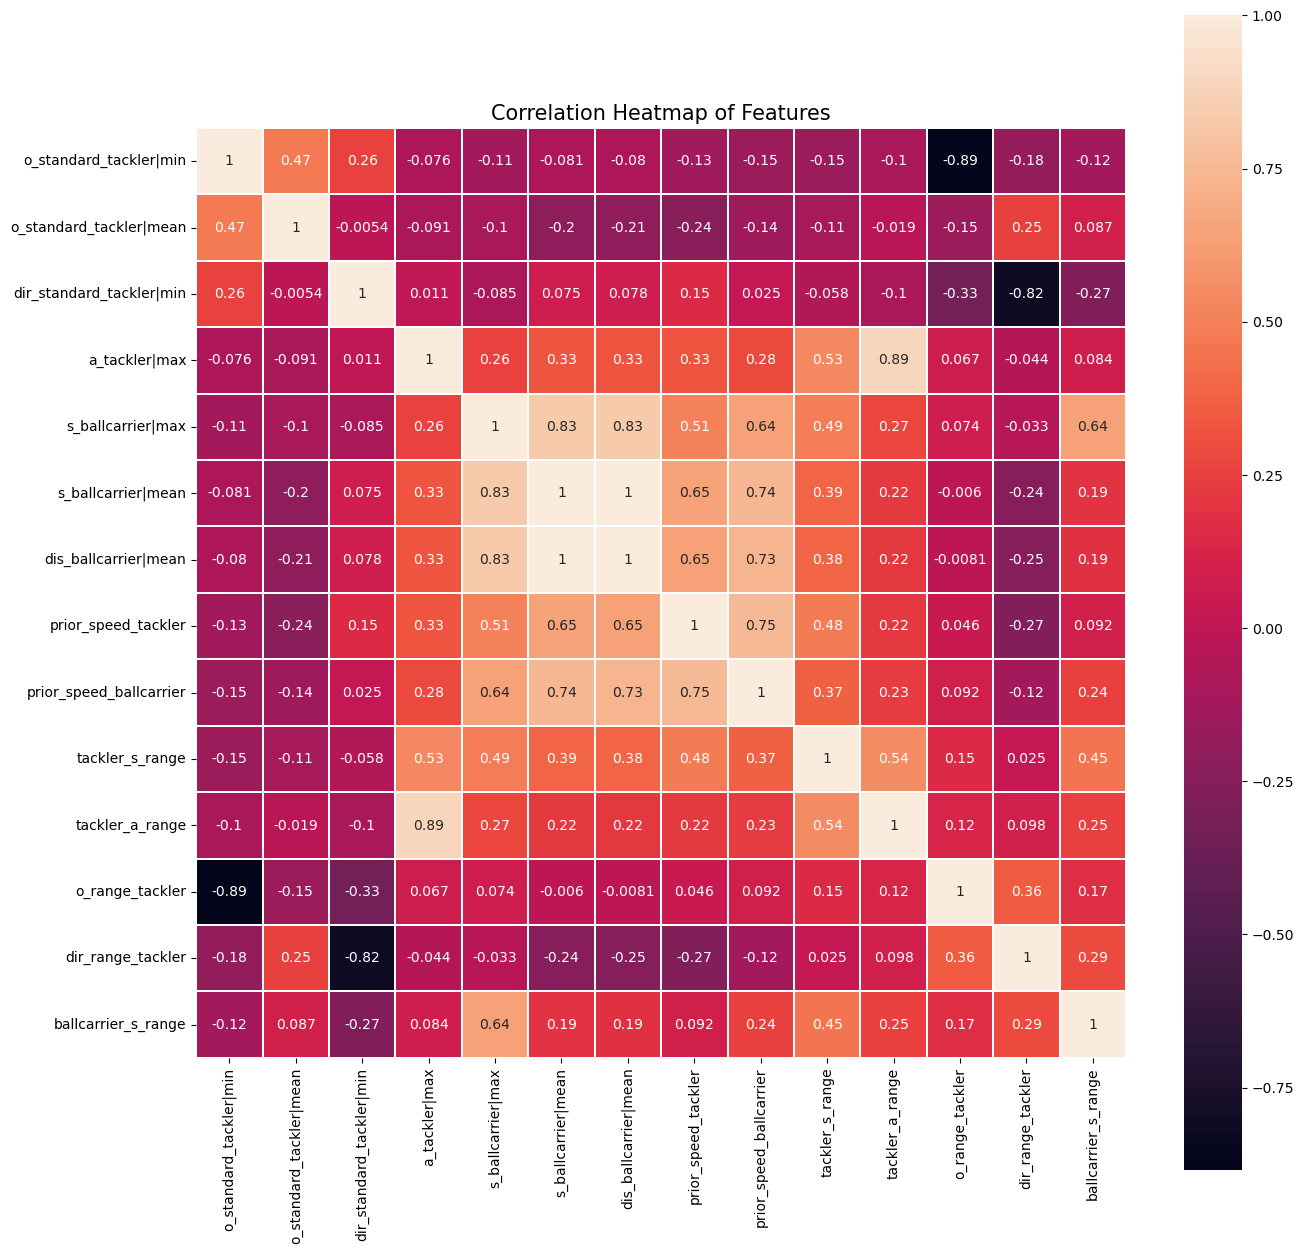

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_final_subset[final_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [47]:
df_set=df_final[['displayName', 'tackle|max','assist|max','pff_missedTackle|max',
               'o_standard_tackler|min',
 'o_standard_tackler|mean',
 'dir_standard_tackler|min',
 'a_tackler|max',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 'dis_ballcarrier|mean',
 'prior_speed_tackler',
 'prior_speed_ballcarrier',
 'tackler_s_range',
 'tackler_a_range',
 'o_range_tackler',
 'dir_range_tackler',
 'ballcarrier_s_range'
]].groupby(by=['displayName']).mean().reset_index()
df_set

df_set_gameplays=df_final[['displayName', 'gameplayid']].groupby(by='displayName').nunique().reset_index()
df_set_tackleassist=df_final[['displayName', 'tackle_assist_success', 'pff_missedTackle|max', 'assist|max', 'tackle|max']].groupby(by='displayName').sum().reset_index()
df_set['gameplayid|nunique']=df_set_gameplays['gameplayid']
df_set[['tackle_assist_count', 'missedTacklecount', 'assist_count', 'tackle_count']]=df_set_tackleassist[['tackle_assist_success', 'pff_missedTackle|max','assist|max', 'tackle|max']]


## My Key Takeaways

I looked at the relationship between the different features and tackle success, missed tackles, and forced fumbles. Based on some of the correlations, I decided to hold on to the following features to start building a predictive model:


### Comparing Algorithms
We'll start by testing 3 classification models: Linear Discriminant Analysis, K Neighbors Classifier, and LGBM Classifier.
1. LDA finds a linear combination of features to separate classes of data. It is used for both dimensionality reduction and classification problems.
2. KNeighbors is an algorithm that takes more computing power, but it is easy to implement and adapts to new data as it comes in.
3. LGBM is our preferred model for this project because it is highly efficient, it can work with large or small datasets, and incoroporates the concept of parallel learning. 

All three models have their advantages and disadvantages, but we will start by comparing the untuned models to see which should be pursued further.

Defaulting to user installation because normal site-packages is not writeable


LDA: 0.827502 (0.003935)
[LightGBM] [Info] Number of positive: 7536, number of negative: 1609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9145, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824057 -> initscore=1.544079
[LightGBM] [Info] Start training from score 1.544079
[LightGBM] [Info] Number of positive: 7536, number of negative: 1609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9145, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824057 -> inits

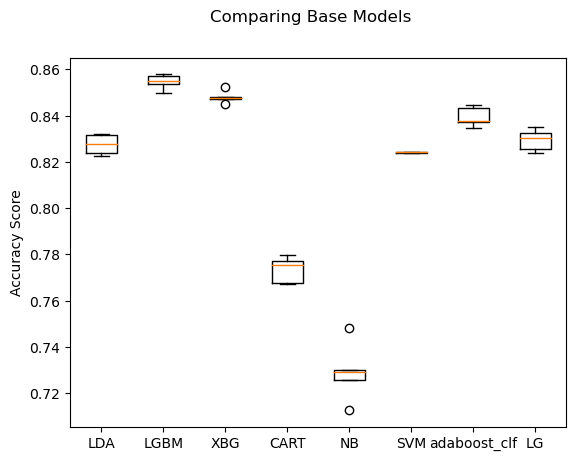

In [48]:
# Compare Algorithms
!pip install xgboost
import pandas
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
df_final2=df_final[df_final['event']!=2]
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
##models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XBG', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('adaboost_clf', AdaBoostClassifier(
    estimator=weak_learner,
    algorithm="SAMME",
    random_state=42,
)))
models.append(('LG', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    
    cv_results = model_selection.cross_val_score(model, X, y,  cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparing Base Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()

The boxplot above compares the accuracy of the three models. It is clear that LGBM has the highest accuracy and therefore we will continue to tune this model.

In [49]:
#!pip install optuna
import optuna  # pip install optuna
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    }
    gbm = LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [50]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)


[I 2023-12-17 15:30:25,782] A new study created in memory with name: lightgbm


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-17 15:30:25,987] Trial 0 finished with value: 0.8523442967109867 and parameters: {'lambda_l1': 1.5706255634406667e-08, 'lambda_l2': 6.293509940445954e-07, 'num_leaves': 127, 'feature_fraction': 0.8668827106724246, 'bagging_fraction': 0.8984243825167065, 'bagging_freq': 3, 'min_child_samples': 91, 'learning_rate': 0.09985634033187472}. Best is trial 0 with value: 0.8523442967109867.
[I 2023-12-17 15:30:26,256] Trial 1 finished with value: 0.8505948215535339 and parameters: {'lambda_l1': 2.2389996134493565e-05, 'lambda_l2': 0.02469416797531678, 'num_leaves': 130, 'feature_fraction': 0.7627140369301474, 'bagging_fraction': 0.6302454925371914, 'bagging_freq': 6, 'min_child_samples': 11, 'learning_rate': 0.0886538879269008}. Best is trial 0 with value: 0.8523442967109867.
[I 2023-12-17 15:30:26,353] Trial 2 finished with value: 0.8240027991602519 and parameters: {'lambda_l1': 0.0055349330575901814, 'lambda_l2': 4.362454954856611e-05, 'num_leaves': 238, 'feature_fraction': 0.56837

## LGBM best params


In [51]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 3.6085139811701076e-06, 'lambda_l2': 1.4445142815935609e-07, 'num_leaves': 42, 'feature_fraction': 0.9132921328866596, 'bagging_fraction': 0.8695234373506034, 'bagging_freq': 6, 'min_child_samples': 100, 'learning_rate': 0.04786432147751675}


In [52]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    gbm =XGBClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="xgb", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2023-12-17 15:30:43,307] A new study created in memory with name: xgb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-17 15:30:43,689] Trial 0 finished with value: 0.8470958712386284 and parameters: {'max_depth': 9, 'learning_rate': 0.02465330481951906, 'n_estimators': 277, 'min_child_weight': 1, 'gamma': 0.004314986640648632, 'subsample': 0.0687646482725966, 'colsample_bytree': 0.6786397077558467, 'reg_alpha': 1.3249400624905015e-07, 'reg_lambda': 6.200192064874551e-07}. Best is trial 0 with value: 0.8470958712386284.
[I 2023-12-17 15:30:44,089] Trial 1 finished with value: 0.8337998600419874 and parameters: {'max_depth': 8, 'learning_rate': 0.4247732074810578, 'n_estimators': 465, 'min_child_weight': 7, 'gamma': 0.004790930618449845, 'subsample': 0.7348578961226092, 'colsample_bytree': 0.40526612847992977, 'reg_alpha': 1.6964837209381136e-05, 'reg_lambda': 0.002276857124308586}. Best is trial 0 with value: 0.8470958712386284.
[I 2023-12-17 15:30:44,294] Trial 2 finished with value: 0.7872638208537439 and parameters: {'max_depth': 8, 'learning_rate': 0.689716344718334, 'n_estimators': 348,

## XGBoost Best Params

In [53]:
print('Best parameters:', study.best_params)

Best parameters: {'max_depth': 5, 'learning_rate': 0.03191395839737685, 'n_estimators': 345, 'min_child_weight': 9, 'gamma': 3.677559081809008e-07, 'subsample': 0.4196989160464899, 'colsample_bytree': 0.9435700578863693, 'reg_alpha': 3.0188126586388915e-07, 'reg_lambda': 6.584352401713505e-05}


In [54]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
    'n_estimators': trial.suggest_int("n_estimators", 10, 200, log=True),
    'max_depth' : trial.suggest_int("max_depth", 2, 32),
    'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
    'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
    }
    rf =RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    prob = rf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2023-12-17 15:31:09,573] A new study created in memory with name: rf


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-17 15:31:12,237] Trial 0 finished with value: 0.8551434569629112 and parameters: {'n_estimators': 124, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8551434569629112.
[I 2023-12-17 15:31:13,163] Trial 1 finished with value: 0.824702589223233 and parameters: {'n_estimators': 85, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8551434569629112.
[I 2023-12-17 15:31:13,724] Trial 2 finished with value: 0.8484954513645906 and parameters: {'n_estimators': 25, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8551434569629112.
[I 2023-12-17 15:31:15,994] Trial 3 finished with value: 0.8526941917424773 and parameters: {'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8551434569629112.
[I 2023-12-17 15:31:17,453] Trial 4 finished with value: 0.853743876836949 and parameters: {'n_e

## RF Best Params

In [55]:
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 101, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 8}


In [56]:
lgbmparams={'lambda_l1': 4.050150332778803e-08, 'lambda_l2': 0.008396253957140833, 'num_leaves': 249, 'feature_fraction': 0.646934695345336, 'bagging_fraction': 0.45014301555842917, 'bagging_freq': 1, 'min_child_samples': 98, 'learning_rate': 0.07472318306842454, 'class_weight':{0:3, 1:1}}
xgbparams= {'max_depth': 6, 'learning_rate': 0.061078105713091524, 'n_estimators': 188, 'min_child_weight': 6, 'gamma': 3.1911859793846633e-05, 'subsample': 0.6397493674824285, 'colsample_bytree': 0.539143847097296, 'reg_alpha': 5.6540580944227995e-06, 'reg_lambda': 3.13066153115124e-05}
rfparams={'n_estimators': 133, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 1}

# 6. Modeling  <a class="anchor"  id="6"></a>

Accuracy: 0.8240027991602519
F1: 0.45175522731632456
Precision: 0.41200139958012594
Recall: 0.5
Kappa: 0.0
AUC:  0.5


Text(0.5, 1.0, 'Confusion Matrix')

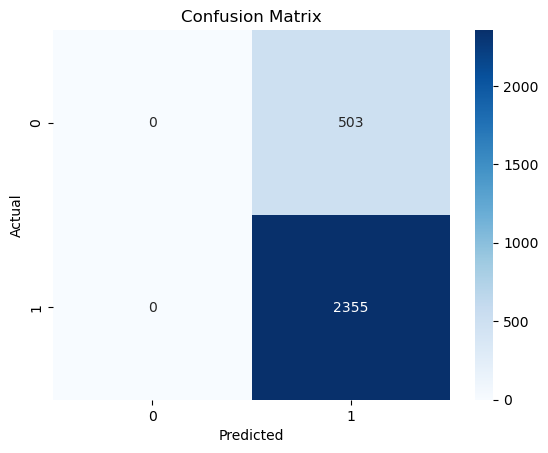

In [57]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score




dummy_clf = DummyClassifier(strategy="most_frequent")
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.25, random_state=0)

dummy_clf.fit(X_train, y_train)



y_pred =  dummy_clf.predict(X_test)
y_proba=dummy_clf.predict_proba(X_test)
matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_test, y_pred,average='macro'))
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))

print("AUC: ", roc_auc_score(y_test, y_pred))


sns.heatmap(matrix, annot=True,  cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

After utilizing libraries for hyperparameter tuning, we arrived at the best paramaters for our LGBM classifier, which is implemented below. 

The next part of the notebook focuses on predicting if a tackle/assist was successful based on the conditions of the play, the tackler, and the player being tackled.

## Predicting a Successful Tackle

We want to ensure that our model isn't overfitting to the training data, so we will implement KFold cross validation to split the data into multiple train-test splits and assess the model's performance each time.

We will repeat this process and plot a confusion matrix, which shows the true positives (successful tackles), true negatives (actual missed tackles), false positives (missed tackles that we predict are successful), and false negatives (successful tackles that we predict are misses).

[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] lambda_l2 is set=0.008396253957140833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008396253957140833
[LightGBM] [Warning] bagging_fraction is set=0.45014301555842917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45014301555842917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] la

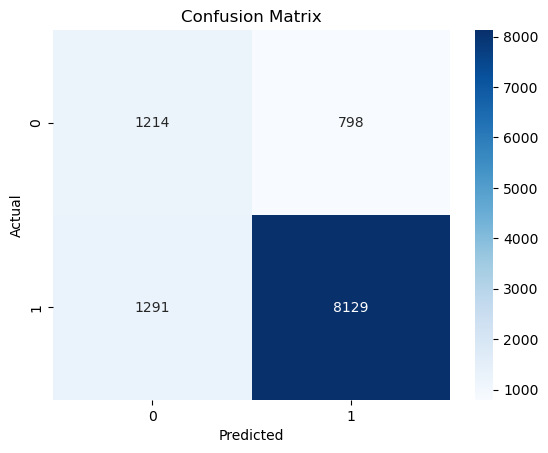

In [58]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from typing import Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

model =LGBMClassifier(**lgbmparams)
X=df_final2[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final2['displayName']
y=df_final2['event']

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array]:

    kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
    groups=df_final2['displayName']
    
    
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X, y):

        X_train, y_train, X_test, y_test = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
       
        
        model.fit(
            X_train, y_train
        )


        


      
        actual_classes = np.append(actual_classes, y_test)
        

        predicted_classes = np.append(predicted_classes, model.predict(X_test))

        try:
            predicted_proba = np.append(predicted_proba, model.predict_proba(X_test), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    print("Accuracy:", accuracy_score(actual_classes, predicted_classes))

    print("F1:", f1_score(actual_classes, predicted_classes,average='macro'))
    print("Precision:", precision_score(actual_classes, predicted_classes,average='macro'))
    print("Recall:", recall_score(actual_classes, predicted_classes,average='macro'))
    print("Kappa:" , cohen_kappa_score(actual_classes, predicted_classes))
    print("AUC: ",  roc_auc_score(actual_classes, predicted_classes))
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()
    
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8545311406578027
F1: 0.6812442546292805
Precision: 0.7737765065167003
Recall: 0.6494627774752757
Kappa: 0.37343961501934975
AUC:  0.6494627774752757


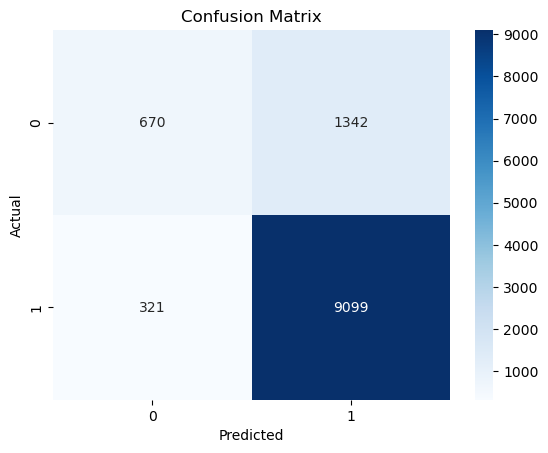

In [59]:
model=XGBClassifier(**xgbparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8518194541637508
F1: 0.6481210100695152
Precision: 0.7904562748460419
Recall: 0.6185027837222947
Kappa: 0.3168969331662772
AUC:  0.6185027837222947


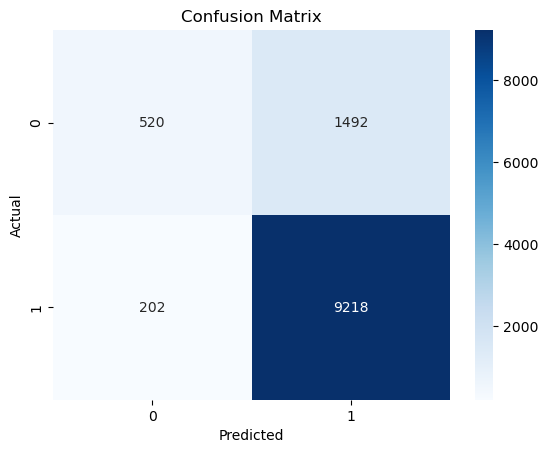

In [60]:
model=RandomForestClassifier(**rfparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] lambda_l2 is set=0.008396253957140833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008396253957140833
[LightGBM] [Warning] bagging_fraction is set=0.45014301555842917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45014301555842917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] la

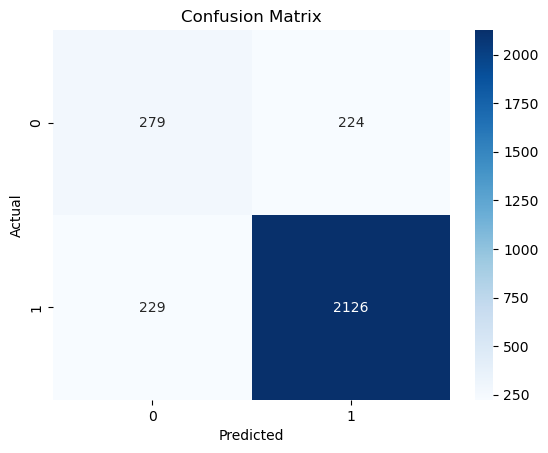

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.25, random_state=0)

#model1=XGBClassifier(**xgbparams)
#model1.fit(X_train, y_train)
#probs1=model1.predict_proba(X)
model2=LGBMClassifier(**lgbmparams)
model2.fit(X_train, y_train)
probs2=model2.predict_proba(X_test)
model3=RandomForestClassifier(**rfparams)
model3.fit(X_train, y_train)
probs3=model3.predict_proba(X_test)
#df_final['prob_tackle1']=probs1[:, 1]
#df_final['prob_miss1']=probs1[:, 0]


X_test['prob_tackle2']=probs2[:, 1]
X_test['prob_miss2']=probs2[:, 0]



X_test['prob_tackle3']=probs3[:, 1]
X_test['prob_miss3']=probs3[:, 0]


X_test['prob_tackle']=((X_test['prob_tackle2']*3)+X_test['prob_tackle3'])/4
X_test['prob_miss']=((X_test['prob_miss2']*3)+X_test['prob_miss3'])/4

X_test['prediction']=np.where(X_test['prob_tackle']>.5, 1, 0)

X_test['y_test']=y_test

len(X_test[X_test['y_test']==X_test['prediction']])/len(X_test)
plot_confusion_matrix(X_test['y_test'], X_test['prediction'], [0,1])

# 7. Explaining the Model  <a class="anchor"  id="7"></a>

Now that we have a model that predicts whether a tackle attempt will be successful with approximately 83% accuracy, we will work to explain the model with shap. 

## What influences Raw Tackle Ability?
The features displayed below were entered into our predictive model and the 'gain' score tells you how influential the feature is in the model compared to the other features. These are the top 10 features:


In [62]:


gain_importance = model2.feature_importances_

# Display feature importance with feature names
feature_names =  final_cols
 

gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(10)


Feature  Gain
1   o_standard_tackler|mean   295
10          tackler_a_range   256
8   prior_speed_ballcarrier   245
12        dir_range_tackler   233
0    o_standard_tackler|min   231
13      ballcarrier_s_range   229
7       prior_speed_tackler   223
11          o_range_tackler   213
3             a_tackler|max   201
9           tackler_s_range   200

In [63]:

gain_importance = model3.feature_importances_

# Display feature importance with feature names
feature_names =  final_cols
 

gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(10)

Feature      Gain
1    o_standard_tackler|mean  0.122007
12         dir_range_tackler  0.093411
11           o_range_tackler  0.080520
7        prior_speed_tackler  0.073617
0     o_standard_tackler|min  0.072883
8    prior_speed_ballcarrier  0.071741
9            tackler_s_range  0.068962
2   dir_standard_tackler|min  0.066995
13       ballcarrier_s_range  0.065224
10           tackler_a_range  0.064865

# 8. Stats by Player <a class="anchor"  id="8"></a>

** Notes ** 
1. Raw tackling ability
2. Defensive scheme - scheme alignment, tackle probability (likely relative to offense alignment)
3. In play tackle likelihood by player 
- Data points to consider for 2 above:
    - offensive first formation
    - offensive formation at time of snap
    - defensive first formation
    - defensive formation at time of snap
- Data points to consider for 1 above:
    - stats by play by player (ex. x-range by player by play by position)
    - position 
    - raw athletic score vs. actual on field production
    - play speed for tackler
    - vision score
    - time to correct movement after ball carrier established
    - angle of approach

Now we are going to group the raw data by tackler and use the prior model to generate the probability of a player's tackle success. We will generate two unique metrics "probability of tackle" which is the natural tackling ability, and the "tackle_index" which weights players more heavily if they have played in more games.

In [64]:
len(df_set)

795

In [65]:
X=df_set[final_cols]


probs2=model2.predict_proba(X)
probs3=model3.predict_proba(X)


df_set['prob_tackle2']=probs2[:, 1]
df_set['prob_miss2']=probs2[:, 0]



df_set['prob_tackle3']=probs3[:, 1]
df_set['prob_miss3']=probs3[:, 0]


df_set['RTA']=((3*df_set['prob_tackle2'])+df_set['prob_tackle3'])/4




[LightGBM] [Warning] feature_fraction is set=0.646934695345336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.646934695345336
[LightGBM] [Warning] lambda_l1 is set=4.050150332778803e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050150332778803e-08
[LightGBM] [Warning] lambda_l2 is set=0.008396253957140833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008396253957140833
[LightGBM] [Warning] bagging_fraction is set=0.45014301555842917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45014301555842917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [66]:
df_set['tackle_index']=round((df_set['RTA']*(df_set['tackle_count']*1)*(df_set['assist_count']*.5))-((1-df_set['RTA'])*(df_set['missedTacklecount']+1)), 2)

In [67]:

df_tackler_merge=pd.merge(df_players, df_set[['displayName','gameplayid|nunique', 'tackle_assist_count','missedTacklecount', 'tackle_index', 'RTA']], on='displayName')
df_tackler_merge.sort_values(by='tackle_index', ascending=False, inplace=True)
df_tackler_merge.reset_index(inplace=True)
df_tackler_merge.head(30)

index  nflId height  weight   birthDate       collegeName position  \
0     283  46091    6-2     234  1995-11-08           Alabama      ILB   
1     337  46269    6-2     215  1995-08-02              Yale      ILB   
2      65  41243    6-2     250  1992-06-19           Alabama      ILB   
3     618  53509    6-3     223         NaN     Virginia Tech      OLB   
4     274  46077    6-0     230  1997-04-08           Georgia      ILB   
5     340  46304    6-0     236  1996-07-02          Syracuse      OLB   
6     495  52435    6-1     245  1997-10-21        Texas Tech      ILB   
7     413  47971   5-11     224  1996-10-12     West Virginia      ILB   
8     412  47862   5-11     196  1998-02-06          Michigan       CB   
9     444  47956    6-1     240  1996-07-30    North Carolina      ILB   
10    534  52527    6-3     219  1997-08-28      Fresno State      ILB   
11    607  53489    6-3     242         NaN        Ohio State      OLB   
12    280  46086    6-2     215  1996-08-03     Florida State       FS   
13    419  47872    6-1     234  1996-07-29          Stanford      ILB   
14    210  44848   5-10     195  1996-01-10        Washington       SS   
15    475  48516    6-1     240  1996-08-12         Wisconsin      ILB   
16    144  43325    6-1     244  1995-09-03              UCLA      ILB   
17    606  53487    6-0     232         NaN          Missouri      ILB   
18    383  47788    6-0     237  1998-02-17   Louisiana State      ILB   
19    361  46669   5-11     210  1995-07-22  Missouri Western       FS   
20     29  38577    6-0     242  1990-06-27        Utah State      ILB   
21     98  42388    6-0     232  1992-02-29              UCLA      ILB   
22    418  47871    6-2     237  1996-11-13              Utah      MLB   
23     30  38588    6-1     233  1990-01-23          Nebraska      ILB   
24    229  44888    6-3     240  1994-09-22           Florida      ILB   
25    691  54492    6-3     235         NaN              Utah      ILB   
26    239  44925    6-0     202  1993-12-10           Alabama       SS   
27    599  53469    6-0     194         NaN   Central Florida       SS   
28    282  46088    6-4     256  1996-02-08       Boise State      OLB   
29    623  53532    6-2     230         NaN    South Carolina      ILB   

             displayName  gameplayid|nunique  tackle_assist_count  \
0          Rashaan Evans                  86                   80   
1       Foyesade Oluokun                  95                   86   
2            C.J. Mosley                  88                   80   
3          Divine Deablo                  78                   72   
4           Roquan Smith                  88                   81   
5         Zaire Franklin                  90                   78   
6          Jordyn Brooks                  88                   79   
7             David Long                  82                   70   
8             David Long                  82                   70   
9           Cole Holcomb                  70                   66   
10          Mykal Walker                  71                   64   
11           Pete Werner                  76                   69   
12          Derwin James                  72                   67   
13         Bobby Okereke                  75                   71   
14           Budda Baker                  76                   66   
15          T.J. Edwards                  80                   72   
16            Myles Jack                  71                   65   
17           Nick Bolton                  70                   68   
18           Devin White                  66                   60   
19        Jonathan Owens                  68                   61   
20          Bobby Wagner                  60                   59   
21        Eric Kendricks                  73                   64   
22           Cody Barton                  56                   54   
23         Lavonte David                  60         

In [88]:
##must have 10 tackle attempts to get RTA
df_tackler_merge[df_tackler_merge['gameplayid|nunique']>0].sort_values(by='RTA', ascending=False).head(20)

index  nflId height  weight   birthDate          collegeName position  \
636    657  53629   5-11     178         NaN             Kentucky       CB   
665    633  53552   5-11     195         NaN           Texas Tech       CB   
667    622  53531    6-0     182         NaN             Michigan       CB   
664    781  54949    6-3     230         NaN         Fresno State      OLB   
666    728  54578    6-0     191         NaN  Louisiana-Lafayette       FS   
668    788  55105    6-1     220         NaN          Wake Forest      OLB   
670    674  53883   5-10     195         NaN             Nebraska       CB   
669    776  54833    6-0     205         NaN             Illinois       FS   
671    480  48566    6-3     279  01/16/1996               Kansas       DE   
672    484  48780    6-3     245  1994-09-13             Delaware      ILB   
638     38  43336    6-3     212  1993-03-03           Ohio State       WR   
637     37  38852   5-11     195  1990-03-17             Stanford       SS   
673    473  48500    6-1     200  1997-11-05              Alabama       CB   
609    750  54640    6-3     290         NaN            Tennessee       DT   
674    479  48555    6-3     245  1995-08-28             Nebraska      OLB   
675    601  53473    6-1     195         NaN             Kentucky       CB   
676    465  48308    6-4     265  1996-03-19            Tennessee       DE   
677    731  54581    6-5     285         NaN           Iowa State       DE   
678    772  54758    6-4     250         NaN        Norfolk State      OLB   
640    262  45215    6-1     230  1994-09-26           Cincinnati      OLB   

          displayName  gameplayid|nunique  tackle_assist_count  \
636    Brandin Echols                   2                    2   
665   Zech McPhearson                   2                    2   
667      Ambry Thomas                   2                    2   
664       Arron Mosby                   1                    1   
666      Percy Butler                   1                    1   
668    Luke Masterson                   2                    2   
670   Dicaprio Bootle                   1                    1   
669        Tony Adams                   1                    1   
671       Daniel Wise                   1                    1   
672       Troy Reeder                   1                    1   
638    Michael Thomas                   2                    2   
637    Michael Thomas                   2                    2   
673     Saivion Smith                   1                    1   
609    Matthew Butler                   3                    3   
674      Luke Gifford                   1                    1   
675     Kelvin Joseph                   1                    1   
676   Jonathan Kongbo                   1                    1   
677  Eyioma Uwazurike                   3                    3   
678    De'Shaan Dixon                   1                    1   
640       Eric Wilson                   2                    2   

     missedTacklecount  tackle_index       RTA  
636                  0          0.49  0.993854  
665                  0         -0.01  0.990498  
667                  0         -0.01  0.988275  
664                  0         -0.01  0.987334  
666                  0         -0.01  0.986327  
668                  0         -0.02  0.977847  
670                  0         -0.03  0.974094  
669                  0         -0.03  0.967630  
671                  0         -0.03  0.966271  
672                  0         -0.03  0.966075  
638                  0          0.45  0.963879  
637                  0          0.45  0.963879  
673                  0         -0.04  0.960918  
609                  0          0.92  0.959533  
674                  0         -0.04  0.959097  
675                  0         -0.04  0.956003  
676                  0         -0.05  0.951534  
677                  0         -0.05  0.948100  
678                  0         -0.06  0.944272  

<center><span style="font-size:36px;">  C.J. Mosley vs. Tony Adams</span> </center>

 <center><img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/h0j0fahb2xtffumugal3.png" alt="CJ Mosley" width="400"/>
  <img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/jtsntdaohmgigyike1hq.png" alt="Tony Adams" width="400"/></center>

In [95]:
df_tackler_merge[(df_tackler_merge['displayName']=='C.J. Mosley') | (df_tackler_merge['displayName']=='Tony Adams')]


index  nflId height  weight   birthDate collegeName position  \
2       65  41243    6-2     250  1992-06-19     Alabama      ILB   
669    776  54833    6-0     205         NaN    Illinois       FS   

     displayName  gameplayid|nunique  tackle_assist_count  missedTacklecount  \
2    C.J. Mosley                  88                   80                  8   
669   Tony Adams                   1                    1                  0   

     tackle_index       RTA  
2          507.29  0.680219  
669         -0.03  0.967630

# 9. NFL Use Cases <a class="anchor"  id="9"></a>

# How is this useful and innovative?
We anticipate several use cases for our predictive model:
1. **Drafting new players** - based on tracking stats from prior tackle attempts, coaches and determine if a new player's RTA makes them a good candidate for their team
2. **Adding to the PFF Player Grades** - We recommend adding a Tackle Grade in the PFF Player Grade cards. 
3. **Visualizations for interpretability** - Each player can have a visual like the one below that shows what aspects of their behavior went into their RTA and Tackle Index. In the example below, Rashaan Evans average orientation of 223 increases his RTA, while his orientation range decreases his RTA. 
4. **Monitoring Player Progress** - If a player's RTA starts to drop, it can mean that they are playing more inconsistently in terms of their tackling outcomes

## RTA = .83 | Tackle Index = 67.92

## Tackle Index Calculation
The tackle index is relative to other players. It can be negative, zero , or positive depending on the previous tackles and missed tackles that the player has made. On the other hand, RTA always ranges from 0 to 1.

# ${RTA \times Tackle Assist Count} -{[{(1-RTA) \times Missed Tackle Count}]} $

# 10. Animations/Gif <a class="anchor"  id="10"></a>

Base function courtesy of: https://www.kaggle.com/code/colinlagator/play-animation-create-gifs-in-python

In [72]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import copy

# Color are courtesy of this kaggle post:
# https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#007FC8", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

def get_blank_field():
    yardlines = np.arange(100, 1100+1, 100)
    yardline_width = 4
    
    yard_mark = list(np.arange(0, 50, 10)) + [50] + list(reversed(list(np.arange(0, 50, 10))))
    font_size=40

    # Draw a green rectangle
    field = Image.new("RGB", (1200, 533), "green")
    draw = ImageDraw.Draw(field)
    
    # Draw the yardlines and the yard marker text
    assert yardline_width % 2 == 0
    for yl, ym in zip(yardlines, yard_mark):
        yl_x = (yl - (yardline_width / 2))
        draw.line([(yl_x, 0), (yl_x, 533)], width = yardline_width, fill="white")
        
        
        draw.text((yl-(font_size/2), 533-(font_size+5)), str(ym),  fill = "black")
    
    # Flip the image so the text is right side up
    field = field.transpose(1)

    return field
def draw_play_frame(frame, highlight_ids = []):

    field = get_blank_field()
    draw = ImageDraw.Draw(field)

    p_rad = 6
    padding=2
    fb_w=8
    fb_h=5
    
    df = copy.deepcopy(frame)
    
    # Round the player locations to work in the image coordinates
    plot_x = df.loc[:, "x"].apply(lambda x: round(x, 1) * 10)
    df.loc[:, "plot_x"] = plot_x
    plot_y = df.loc[:, "y"].apply(lambda x: round(x, 1) * 10)
    df.loc[:, "plot_y"] = plot_y
        
    for row in df.iterrows():
        
        x = row[1]["plot_x"]
        y = row[1]["plot_y"]
        
        # Draw a white circle behind any player dots to be highlighted
        if row[1]["nflId"] in highlight_ids:
            draw.ellipse(((x-p_rad)-padding, (y-p_rad)-padding, (x+p_rad)+padding, (y+p_rad)+padding), fill="white")

        # Draw the football
        if row[1]["club"] == "football":
            draw.ellipse((x-fb_w, y-fb_h, x+fb_w, y+fb_h), fill=colors[row[1]["club"]])
        # Draw the players with color according to the colors dictionary
        else:
            draw.ellipse((x-p_rad, y-p_rad, x+p_rad, y+p_rad), fill=colors[row[1]["club"]])
        
    return field

def finalize(field, min_x = None, max_x = None):
    """
    Finalizes the image. Does the following
    - Flips the image along the x axis
    - Optionally crops out empty field according to min_x, max_x
    """
    field = field.transpose(1)
    if (min_x is not None) & (max_x is not None):
        field = field.crop((min_x, 0, max_x, 533))

    return field
def create_play_gif(play_player_tracking_df, gif_name, crop=False, highlight_ids=[]):
    """
    Draws the play frame by frame and saves to gif
    
    Parameters
    play_player_tracking_df - A df of player_tracking_data that contains 
    a unique gameId and a unique playId
    gif_name - The name of the gif, minus the .gif extension. This is 
    added automatically.
    crop - Whether or not to crop the gif to only contain the minimum and
    maximum x values within the entire play
    highlight_ids - The ids of players to draw a white circle behind them in
    order to call attention to them.
    
    """
    min_x = (round(play_player_tracking_df.x.min(), 1) * 10) - 50
    max_x = (round(play_player_tracking_df.x.max(), 1) * 10) + 50
    
    gif_frames = []
    frames = play_player_tracking_df["frameId"].values
    for i in frames:
        frame = play_player_tracking_df[play_player_tracking_df["frameId"] == i].copy(deep=True)
        field = get_blank_field()
        
        field = draw_play_frame(frame, highlight_ids)
            
        if crop:
            field = finalize(field, min_x = min_x, max_x =  max_x)
        else:
            field = finalize(field)
            
        gif_frames.append(field)
    frame_one = gif_frames[0]
    print(frame_one)
    frame_one.save(f"{gif_name}.gif", format="GIF", append_images=gif_frames,
                save_all=True, duration=100, loop=0)

    return gif_name
# Display the gif
def show_gif(gif_name):
    import base64
    from IPython import display
    
    with open(str(gif_name)+".gif", 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

<PIL.Image.Image image mode=RGB size=1200x533 at 0x203B33B51B0>



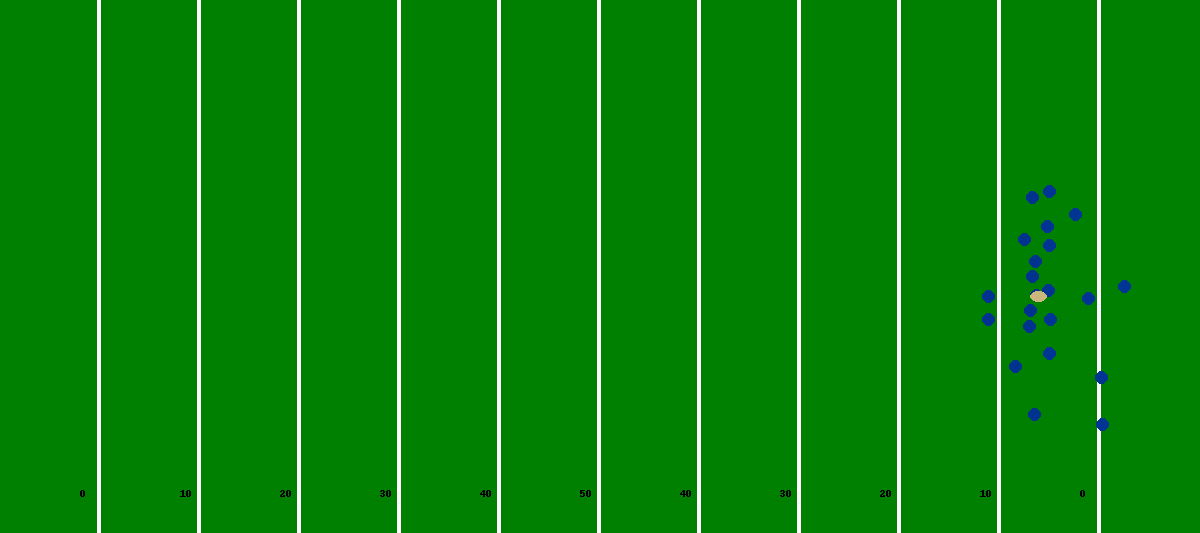

In [73]:
gameplay='20220908002712'


     
show_gif(create_play_gif(df_tracking[df_tracking['gameplayid']==gameplay], str(gameplay)+'.gif'))




# Data Dictionary
## Tackles data
- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players (numeric)
- **tackle:** Indicator for whether the given player made a tackle on the play (binary)
- **assist:** Indicator for whether the given player made an assist tackle on the play (binary)
- **forcedFumble:** Indicator for whether the given player forced a fumble on the play (binary)
- **pff_missedTackle:** Provided by Pro Football Focus (PFF). Indicator for whether the given player missed a tackle on the play (binary)

## Tracking data

- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
- **displayName:** Player name (text)
- **frameId:** Frame identifier for each play, starting at 1 (numeric)
- **time:** Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
- **jerseyNumber:** Jersey number of player (numeric)
- **club:** Team abbrevation of corresponding player (text)
- **playDirection:** Direction that the offense is moving (left or right)
- **x:** Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
- **y:** Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
- **s:** Speed in yards/second (numeric)
- **a:** Speed in yards/second^2 (numeric)
- **dis:** Distance traveled from prior time point, in yards (numeric)
- **o:** Player orientation (deg), 0 - 360 degrees (numeric)
- **dir:** Angle of player motion (deg), 0 - 360 degrees (numeric)
- **event:** Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

# Resources Used


- https://francis-press.com/uploads/papers/ndkLZY5nQLH6nilaE0nfMi0dxkAogA90wpqUB2vK.pdf
- https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1079&context=cbbbpapers
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9459770/
- https://www.frontiersin.org/articles/10.3389/fspor.2021.669845/full
- https://entertainment.howstuffworks.com/physics-of-football.htm